In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.utils.data import Dataset, DataLoader, DistributedSampler
from torch.multiprocessing.spawn import spawn
import torchvision.models as models
import torchvision.datasets as dst
from torchvision.io import read_image
from torchvision.transforms import v2

In [19]:
# settings
DATA_PATH = "/export/space0/yanai/media/foodimg128/omurice/"


In [20]:
def transform_for_sketch(img):
    transforms = v2.Compose([
        v2.ToTensor(),
        v2.Grayscale(num_output_channels=1), #念の為
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5,), (0.5,))   # [0,1]→[-1,1]
    ])
    return transforms(img)



In [21]:
# dataset = CustomDataset(DATA_PATH)
# img, img2 = dataset[0]

In [22]:
# plt.imshow(img.permute(1,2,0), cmap='gray')
# plt.show()

In [23]:
# plt.imshow(img2.permute(1,2,0))
# plt.show()

### 検証

In [24]:
def transform_for_sketch(img):
    transforms = v2.Compose([
        v2.Grayscale(num_output_channels=1), #念の為
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5,), (0.5,))   # [0,1]→[-1,1]
    ])
    return transforms(img)

class Generator(nn.Module):
    def __init__(self, in_ch=1, out_ch=3, ngf=64):
        super().__init__()
        # encoder
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch,    ngf,   4, 2, 1, bias=False),  # 256→128
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ngf,      ngf*2, 4, 2, 1, bias=False),  # 128→64
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ngf*2,    ngf*4, 4, 2, 1, bias=False),  # 64→32
            nn.BatchNorm2d(ngf*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ngf*4,    ngf*8, 4, 2, 1, bias=False),  # 32→16
            nn.BatchNorm2d(ngf*8),
            nn.LeakyReLU(0.2, True),
        )
        # decoder
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),  # 16→32
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),  # 32→64
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf,   4, 2, 1, bias=False),  # 64→128
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf,   out_ch,4, 2, 1),               # 128→256
            nn.Tanh(),
        )

    def forward(self, x):
        z = self.enc(x)
        return self.dec(z)

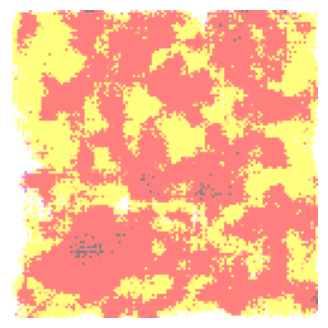

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data
data_path = "/export/space0/yanai/media/foodimg128/omurice/hed0999.png"
img = read_image(transform_for_sketch(data_path))
img = img.unsqueeze(0).to(device).float()

# model
model = Generator()
model.load_state_dict(torch.load("9_1_pix2pix.pth"))
model = nn.DataParallel(model.to(device))

model.eval()
with torch.no_grad():
    styled_img = model(img)

# 可視化
def reprocessing(img):
    if img.ndim == 3:      # (C,H,W) → (1,C,H,W) に合わせる
        img = img.unsqueeze(0)
    img = (img + 1.) / 2.
    mean = torch.tensor([0.5, 0.5, 0.5], device=img.device).view(1,3,1,1)
    std  = torch.tensor([0.5, 0.5, 0.5], device=img.device).view(1,3,1,1)
    img = img * std + mean              
    return img.clamp(0,1).squeeze(0) #clamp()は念の為

vis = reprocessing(styled_img)
plt.figure(figsize=(4,4))
plt.imshow(vis.cpu().permute(1,2,0))
plt.axis('off')
plt.show()

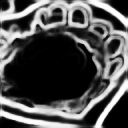

In [27]:
img = Image.open( "/export/space0/yanai/media/foodimg128/omurice/hed0999.png")
img